In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.display import display
from pathlib import Path
from PIL import Image
import os

# set current path to $HOME/Projects/ocean-relic/
current_path = Path(os.path.expandvars('$HOME/Projects/ocean-relic/'))

In [2]:
from collections import namedtuple
from typing import List, Tuple
from matplotlib import pyplot as plt
import cv2
import numpy as np


Point = namedtuple('Point', ['x', 'y'])
BoundingBox = namedtuple('BoundingBox', ['left_top', 'right_top', 'left_bottom', 'right_bottom', 'width', 'height'])


def visualize_regions(
    base: Image.Image,
    regions: List[BoundingBox], 
    color: Tuple[int, int, int] = (0, 255, 0),
    thickness: int = 8
):
    """
    Draw bounding boxes on image, optionally save, and display the 
    original and result side by side using matplotlib.
    Converts the PIL image to cv2 format internally for drawing.
    """
    # Convert PIL Image to cv2 image (numpy array, BGR)
    base_np = np.array(base)
    # PIL Image in RGB, so convert to BGR for OpenCV
    base_cv = cv2.cvtColor(base_np, cv2.COLOR_RGB2BGR)

    # Make a copy to draw on
    result_cv = base_cv.copy()
    for region in regions:
        pt1 = (region.left_top.x, region.left_top.y)
        pt2 = (region.right_bottom.x, region.right_bottom.y)
        cv2.rectangle(result_cv, pt1, pt2, color, thickness)

    # For displaying in matplotlib, convert back to RGB
    orig_rgb = cv2.cvtColor(base_cv, cv2.COLOR_BGR2RGB)
    result_rgb = cv2.cvtColor(result_cv, cv2.COLOR_BGR2RGB)

    # Plot side by side
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(orig_rgb)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('With Detected Regions')
    plt.imshow(result_rgb)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

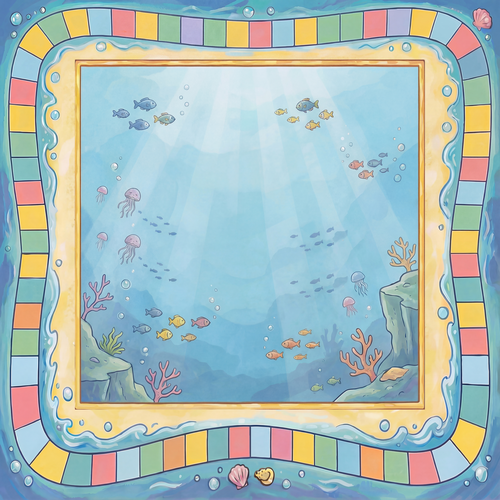

Overlay Bounding Box: BoundingBox(left_top=Point(x=664, y=538), right_top=Point(x=3431, y=538), left_bottom=Point(x=664, y=3305), right_bottom=Point(x=3431, y=3305), width=2867, height=2867)


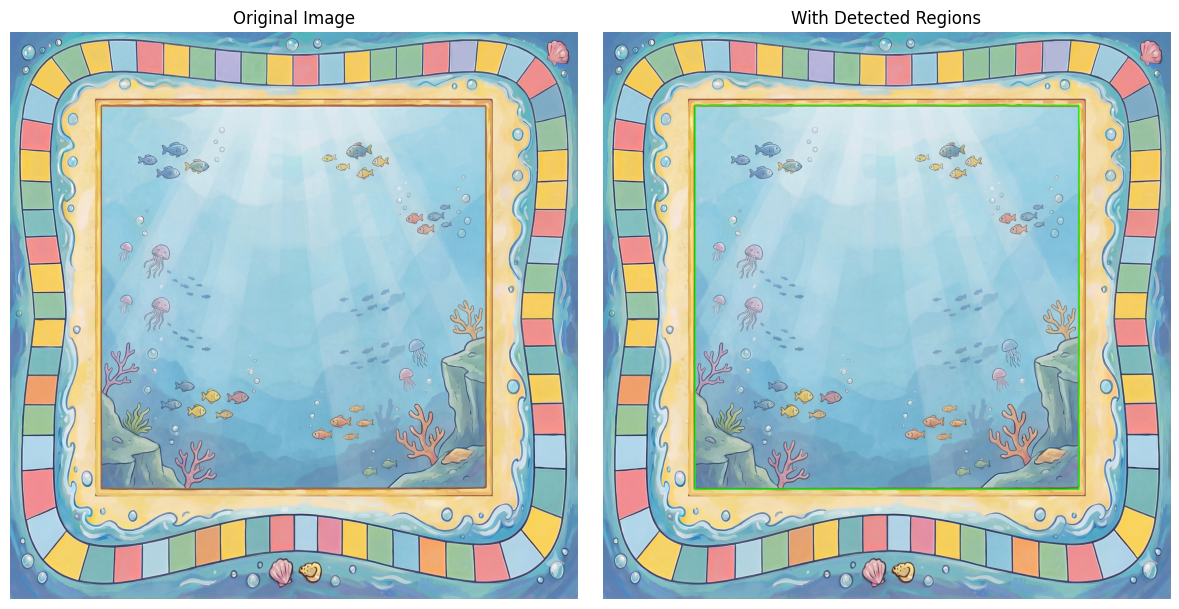

In [3]:
from typing import Tuple

def display_image(img: Image.Image | Path, target_width: int | None = None):
    if isinstance(img, Path):
        img = Image.open(img)

    if target_width is not None:
        # Calculate target height to preserve aspect ratio
        width_percent = target_width / float(img.width)
        target_height = int((float(img.height) * float(width_percent)))
        img = img.resize((target_width, target_height), Image.LANCZOS)

    display(img)

# load the image
base_board_path = current_path / 'src/assets/base-board.png'
base_board = Image.open(base_board_path)

ocean_scene_path = current_path / 'src/assets/ocean-scene.jpeg'
ocean_scene = Image.open(ocean_scene_path)

def overlay_ocean_scene_on_board(
    base: Image.Image,
    overlay: Image.Image,
    scale_ratio: float,
    y_offset: int,
) -> Tuple[Image.Image, BoundingBox]:
    """
    Resize the ocean scene (overlay) and paste it onto the center of the base board.
    Also return the coordinates of the rectangle area where the overlay image was placed (BoundingBox).
    
    Args:
        base: The base board image (PIL.Image).
        overlay: The ocean scene image (PIL.Image).
        scale_ratio: The ratio of overlay size to the base board (0.0 < scale_ratio <= 1.0).
        y_offset: Integer offset (vertical shift of overlay position)
    
    Returns:
        A tuple with:
          - The composited image (PIL.Image)
          - The BoundingBox for the region where overlay appears: 
            a tuple of ((left_top_x, left_top_y), (right_top_x, right_top_y), (left_bottom_x, left_bottom_y), (right_bottom_x, right_bottom_y), width, height)
    """
    # Calculate new overlay size to fit the scale ratio relative to base
    target_width = int(base.width * scale_ratio)
    width_percent = target_width / float(overlay.width)
    target_height = int((float(overlay.height) * float(width_percent)))
    overlay_resized = overlay.resize((target_width, target_height), Image.LANCZOS)
    
    # Calculate position (offset) to center overlay on base (after resize)
    offset_x = (base.width - overlay_resized.width) // 2
    offset_y = (base.height - overlay_resized.height) // 2 - y_offset

    # Compute bounding box coordinates
    frame_thickness = 50
    left = offset_x + frame_thickness
    top = offset_y + frame_thickness
    right = offset_x + overlay_resized.width - frame_thickness
    bottom = offset_y + overlay_resized.height - frame_thickness
    left_top = Point(left, top)
    right_top = Point(right, top)
    left_bottom = Point(left, bottom)
    right_bottom = Point(right, bottom)

    bbox = BoundingBox(
        left_top=left_top,
        right_top=right_top,
        left_bottom=left_bottom,
        right_bottom=right_bottom,
        width=overlay_resized.width,
        height=overlay_resized.height
    )

    # Create a copy so as not to mutate original base
    composite = base.copy()
    # Ensure overlay has alpha if needed for transparency
    if overlay_resized.mode != "RGBA":
        overlay_resized = overlay_resized.convert("RGBA")
    
    composite.paste(overlay_resized, (offset_x, offset_y), overlay_resized)
    return composite, bbox

# Example usage with display output and bounding box
composite_img, overlay_bbox = overlay_ocean_scene_on_board(base_board, ocean_scene, scale_ratio=0.7, y_offset=126)
composite_img.save(current_path / 'src/assets/composite-board.jpeg')
display_image(composite_img, target_width=500)
print("Overlay Bounding Box:", overlay_bbox)

visualize_regions(composite_img, [overlay_bbox])


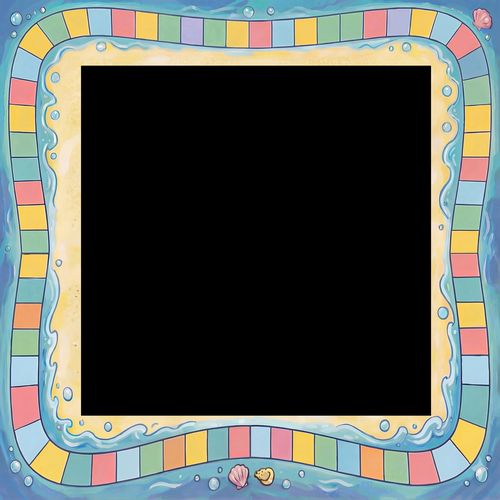

In [4]:
def overlay_on_board(
  base: Image.Image,
  overlay: Image.Image,
  area: BoundingBox,
) -> Image.Image:
  """
  Overlay the overlay image on the base image at the specified area.
  Also return the coordinates of the rectangle area where the overlay image was placed (BoundingBox).
  """
  # Create a copy so as not to mutate original base
  composite = base.copy()

  # Resize overlay to fit specified area dimensions (width, height)
  target_size = (area.width, area.height)
  overlay_resized = overlay.resize(target_size, Image.LANCZOS)

  # Ensure overlay has alpha if needed for transparency
  if overlay_resized.mode != "RGBA":
    overlay_resized = overlay_resized.convert("RGBA")

  # Paste overlay onto composite at top-left corner of BoundingBox
  offset = area.left_top
  composite.paste(overlay_resized, offset, overlay_resized)

  # Return composite and the bounding box (as placed)
  return composite


# Create a pure black image with the same size as base_board
black_img = Image.new("RGB", base_board.size, color=(0, 0, 0))

# Use overlay_ocean_scene_on_board to overlay the ocean scene on the black image
composite_on_black = overlay_on_board(base_board, black_img, overlay_bbox)

composite_on_black.save(current_path / 'src/assets/composite-board-black.jpeg')
# Visualize the result
display_image(composite_on_black, target_width=500)


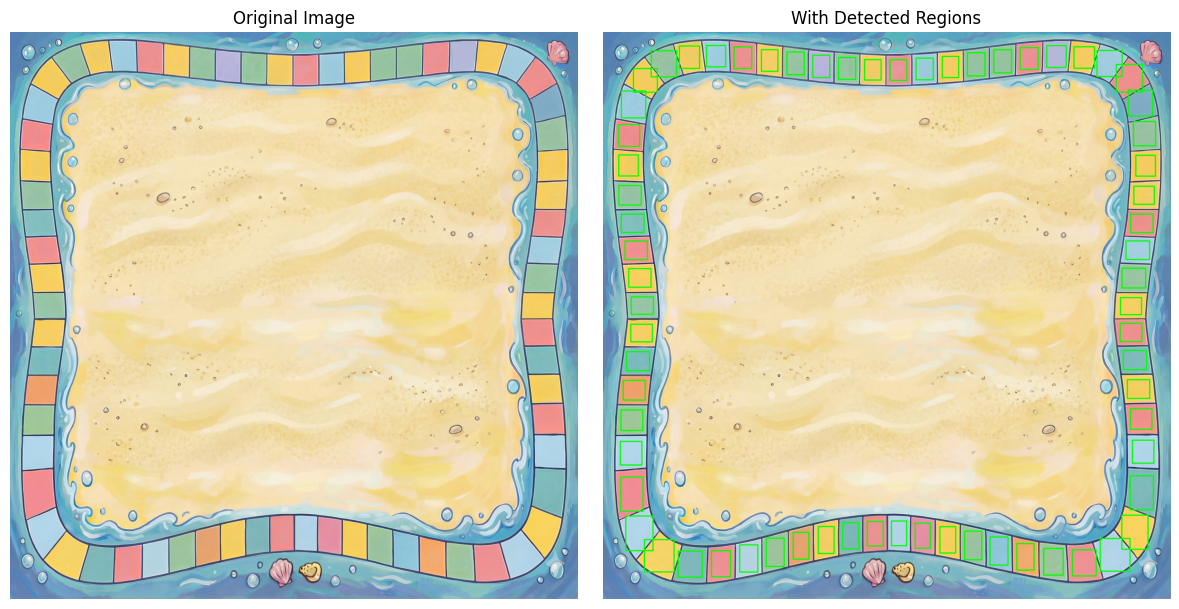

In [5]:
import cv2
import numpy as np
from collections import namedtuple
from typing import List, Tuple
from matplotlib import pyplot as plt

# Named tuples for clean data representation
RGB = namedtuple('RGB', ['r', 'g', 'b'])

class ColorRegionDetector:
    def __init__(self, image_path: str):
        """Initialize with an image file path."""
        self.image = cv2.imread(image_path)
        if self.image is None:
            raise ValueError(f"Could not load image: {image_path}")
        # OpenCV loads as BGR, convert to RGB for easier reasoning
        self.image_rgb = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        self.height, self.width = self.image.shape[:2]
    
    def find_color_regions(
        self, 
        target_colors: List[RGB], 
        threshold: int,
        min_width: int,
        min_height: int,
        max_width: int,
        max_height: int,
    ) -> List[BoundingBox]:
        # Create color mask using Euclidean distance in RGB space for multiple colors
        mask = self._create_color_mask(target_colors, threshold)
        
        # Apply morphological operations to clean up the mask
        mask = self._clean_mask(mask)
        
        # Find connected components
        regions = self._find_connected_regions(mask, min_width, min_height, max_width, max_height)

        regions = self._shrink_regions(regions, 0.7)
        
        return regions

    def _create_color_mask(self, target_colors: List[RGB], threshold: int) -> np.ndarray:
        """Create a binary mask of pixels within threshold of any target color."""
        img = self.image_rgb.astype(np.float32)
        # Initialize blank mask
        mask = np.zeros((self.height, self.width), dtype=np.uint8)

        for target_color in target_colors:
            target = np.array([target_color.r, target_color.g, target_color.b], dtype=np.float32)
            diff = img - target
            distance = np.sqrt(np.sum(diff ** 2, axis=2))
            mask |= (distance <= threshold * np.sqrt(5)).astype(np.uint8)
        
        mask = mask * 255  # Convert boolean mask to uint8 mask with 255 for matched pixels

        return mask
    
    def _clean_mask(self, mask: np.ndarray) -> np.ndarray:
        """Apply morphological operations to clean up the mask."""
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        
        # Close small gaps
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        # Remove small noise
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
        
        return mask
    
    def _find_connected_regions(
        self, 
        mask: np.ndarray, 
        min_width: int,
        min_height: int,
        max_width: int,
        max_height: int,
    ) -> List[BoundingBox]:
        """Find connected components and return their bounding boxes."""
        # Find connected components with statistics
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            mask, connectivity=8
        )
        
        regions = []
        
        # Skip label 0 (background)
        for i in range(1, num_labels):
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            
            # Filter by minimum area
            if w >= min_width and h >= min_height and w <= max_width and h <= max_height:
                bbox = BoundingBox(
                    left_top=Point(x, y),
                    right_top=Point(x + w, y),
                    left_bottom=Point(x, y + h),
                    right_bottom=Point(x + w, y + h),
                    width=w,
                    height=h,
                )
                regions.append(bbox)
        
        return regions

    def _shrink_regions(
        self, 
        regions: List[BoundingBox], 
        shrink_factor: float
    ) -> List[BoundingBox]:
        """Shrink regions by shrinking width/height around the center point."""
        shrunk_regions = []
        for region in regions:
            # Calculate center
            cx = (region.left_top.x + region.right_top.x + region.left_bottom.x + region.right_bottom.x) / 4
            cy = (region.left_top.y + region.right_top.y + region.left_bottom.y + region.right_bottom.y) / 4

            # New width and height
            new_w = region.width * shrink_factor
            new_h = region.height * shrink_factor

            # Recalculate coordinates around center
            left = int(round(cx - new_w / 2))
            right = int(round(cx + new_w / 2))
            top = int(round(cy - new_h / 2))
            bottom = int(round(cy + new_h / 2))

            shrunk = BoundingBox(
                left_top=Point(left, top),
                right_top=Point(right, top),
                left_bottom=Point(left, bottom),
                right_bottom=Point(right, bottom),
                width=right - left,
                height=bottom - top,
            )
            shrunk_regions.append(shrunk)
        return shrunk_regions
    
    def _group_rectangles(
        self, 
        original: List[List[int]], 
        expanded: List[Tuple[int, int, int, int]]
    ) -> List[List[int]]:
        """Group overlapping rectangles using union-find approach."""
        n = len(original)
        if n == 0:
            return []
        
        # Union-find parent array
        parent = list(range(n))
        
        def find(x):
            if parent[x] != x:
                parent[x] = find(parent[x])
            return parent[x]
        
        def union(x, y):
            px, py = find(x), find(y)
            if px != py:
                parent[px] = py
        
        # Check for overlapping expanded rectangles
        def rects_overlap(r1, r2):
            x1, y1, w1, h1 = r1
            x2, y2, w2, h2 = r2
            return not (x1 + w1 < x2 or x2 + w2 < x1 or 
                        y1 + h1 < y2 or y2 + h2 < y1)
        
        # Union overlapping rectangles
        for i in range(n):
            for j in range(i + 1, n):
                if rects_overlap(expanded[i], expanded[j]):
                    union(i, j)
        
        # Group by parent
        groups = {}
        for i in range(n):
            p = find(i)
            if p not in groups:
                groups[p] = []
            groups[p].append(original[i])
        
        # Merge each group into single bounding box
        merged = []
        for group in groups.values():
            min_x = min(r[0] for r in group)
            min_y = min(r[1] for r in group)
            max_x = max(r[0] + r[2] for r in group)
            max_y = max(r[1] + r[3] for r in group)
            merged.append([min_x, min_y, max_x - min_x, max_y - min_y])
        
        return merged


def detect_color_regions(
    image_path: str,
    target_color: RGB,
    threshold: int = 30,
    min_area: int = 100
) -> List[BoundingBox]:
    """
    Convenience function to detect color regions in an image.
    
    Args:
        image_path: Path to the image file
        target_color: RGB namedtuple with target color (e.g., RGB(240, 138, 142))
        threshold: Color matching threshold (0-255)
        min_area: Minimum pixel area for detected regions
    
    Returns:
        List of BoundingBox namedtuples
    """
    detector = ColorRegionDetector(image_path)
    return detector.find_color_regions(target_color, threshold, min_area)


detector = ColorRegionDetector(current_path / 'src/assets/composite-board-black.jpeg')
score_track_regions = detector.find_color_regions(
    target_colors=[
        RGB(r=240, g=138, b=142),  # red
        RGB(r=218, g=146, b=163),  # pink
        RGB(r=182, g=184, b=213),  # dark purple
        RGB(r=187, g=215, b=234),  # light purple
        RGB(r=239, g=208, b=111),  # yellow
        RGB(r=170, g=203, b=220),  # light blue
        RGB(r=139, g=182, b=185),  # tint
        RGB(r=161, g=192, b=165),  # green
        RGB(r=228, g=165, b=116),  # orange
    ],
    threshold=12,      # Adjust for stricter/looser matching
    min_width=150,
    min_height=150,
    max_width=350,
    max_height=400,
)

visualize_regions(base_board, score_track_regions)

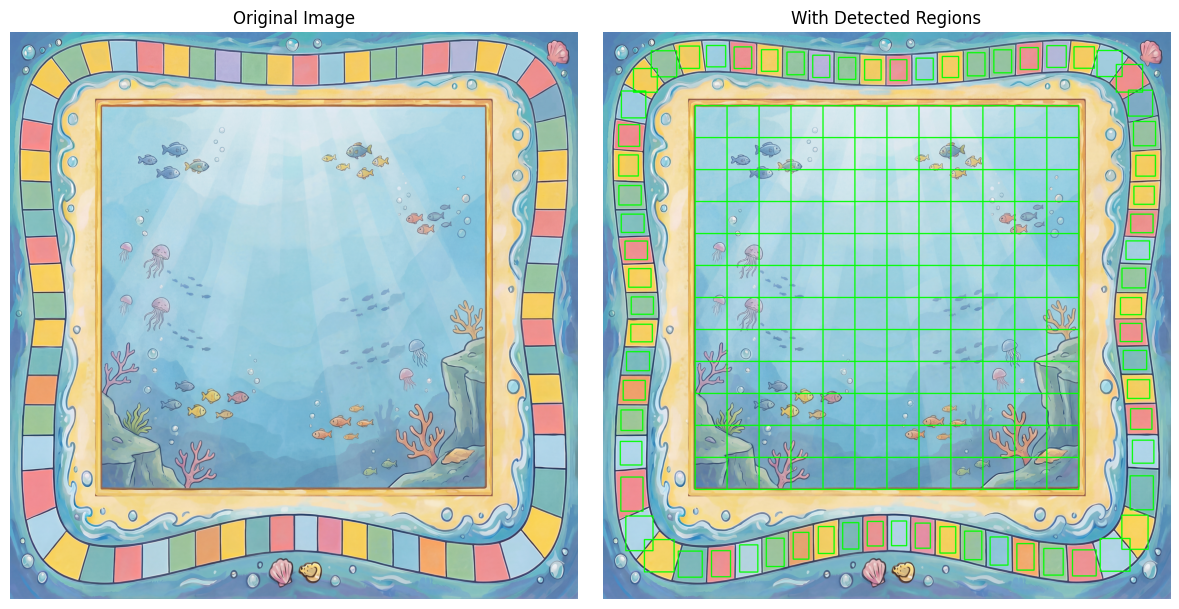

In [6]:
def on_scene_grid_regions(
  scene_bbox: BoundingBox,
  segments: int = 10,
) -> List[BoundingBox]:
  """
  Divide the input scene_bbox into an evenly spaced grid of BoundingBoxes.
  Returns a flat list of grid cell BoundingBoxes (row-major order).
  """
  cells = []
  min_x, min_y = scene_bbox.left_top.x, scene_bbox.left_top.y
  max_x, max_y = scene_bbox.right_bottom.x, scene_bbox.right_bottom.y
  cell_w = (max_x - min_x) / segments
  cell_h = (max_y - min_y) / segments

  for row in range(segments):
    for col in range(segments):
      x0 = int(min_x + col * cell_w)
      y0 = int(min_y + row * cell_h)
      x1 = int(min_x + (col + 1) * cell_w)
      y1 = int(min_y + (row + 1) * cell_h)
      cell_bbox = BoundingBox(
        left_top=Point(x=x0, y=y0),
        left_bottom=Point(x=x0, y=y1),
        right_top=Point(x=x1, y=y0),
        right_bottom=Point(x=x1, y=y1),
        width=x1 - x0,
        height=y1 - y0,
      )
      cells.append(cell_bbox)
  return cells


grid_regions = on_scene_grid_regions(overlay_bbox, 12)

all_mask_regions = score_track_regions + grid_regions

visualize_regions(composite_img, all_mask_regions)  

In [7]:
import json
from pathlib import Path

def bbox_to_dict(bbox):
  return {
    "lt": {"x": bbox.left_top.x, "y": bbox.left_top.y},
    "lb": {"x": bbox.left_bottom.x, "y": bbox.left_bottom.y},
    "rt": {"x": bbox.right_top.x, "y": bbox.right_top.y},
    "rb": {"x": bbox.right_bottom.x, "y": bbox.right_bottom.y},
    "w": bbox.width,
    "h": bbox.height,
  }

score_track_json = [bbox_to_dict(b) for b in score_track_regions]
grid_regions_json = [bbox_to_dict(b) for b in grid_regions]

grid_info_data = {
  "score_track_regions": score_track_json,
  "scene_grid_regions": grid_regions_json,
}

grid_info_path = (current_path / "src/assets/grid_info.json")
with open(grid_info_path, "w") as f:
  json.dump(grid_info_data, f, indent=2)

